<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/book-workflow/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **Sequence 1.1.1: Gridworld Introduction**

### Objective: In this sequence, we will create a simple environment-organism system to demonstrate how an organism's **behaviour**, within an **environment**, can be evaluated using **rewards**. We will also see how intelligent behaviour can lead to better outcomes and how **randomness** can make evaluation of behaviour more difficult.

# Setup
Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path




# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py', 'gw_widgets.py',
             'gw_NN_RL.py']
# A directory to store these utility .py files
Path('utils').mkdir(parents=True, exist_ok=True)
# Get the IPython interactive shell to run/load the utility files
ipython = get_ipython()

for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C1_S1"

Random seed 2021 has been set.
GPU is enabled in this notebook.
Running in colab


# 1.1.1.1: Initializing Gridworld

Before we introduce an organism with **behaviour** we're going to build an **environment** for them to behave in. To start, this world will consist of a 7 x 7 grid. Let's make a picture of that and see what it looks like.

In [2]:
############################################################################
## TODO for students: Replace ... with the correct arguments(inputs) in the
## make_grid function below to make our grid the right size and shape (7x7).
## The function definition is duplicated here for convenience and hackability,
## but in general you can use the tool tip by hovering over the word make_grid,
## when this is the active cell, to find out how to use the make_grid function.
## You can also use the tool tip to view the source code. How does it work?
## Comment out or remove these next two lines.
raise NotImplementedError(
  "Exercise: make a grid using the make_grid function")
############################################################################


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax

fig, ax = make_grid(...)
plt.show()

NotImplementedError: ignored

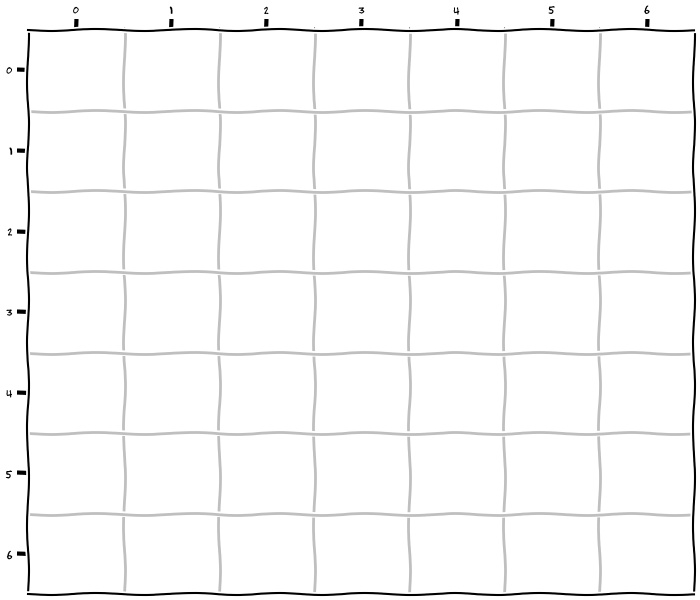

In [3]:
# to_remove solution


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax

with plt.xkcd():
  fig, ax = make_grid(7, 7)
  plt.show()

*Bonus: change the function definition:*

Tweak the make_grid function in the cell above to make the grid lines green.

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per grid cell. To plot these food items we need their locations. We will set these by randomly sampling grid coordinates [without replacement](## "never picking the same (row,col) coordinate pair twice"). We'll place the organism in the same way and not on a food item to start.

In [4]:
################################################################################
# TODO for students: Replace ... in init_loc(...) to initialize the right
# number of food item locations and critter locations in coordinates that make
# sense for our grid environment. Then replace the ... in rc_plotting[...] to
# index the plotting coordinates for the food locations.
# Hint: The syntax for indexing elements of numpy arrays using [] can be
# confusing at first. If you're lost read the docs,
# https://numpy.org/doc/stable/user/basics.indexing.html and add some code
# cells below to play around with indexing and displaying different sub-arrays
# of the rc_plotting array.
# Comment out or remove this next line.
raise NotImplementedError("Exercise: initialize food and critter locations")
################################################################################


def init_loc(n_rows, n_cols, num, rng=None):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int, number of rows in the grid
    n_cols: int, number of columns in the grid
    num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
    rng:    instance of numpy.random's default rng. Used for reproducibility.

  Returns:
    int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
    rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
      the row indices and the second giving the col indices. Useful for indexing into
      an n_rows by n_cols numpy array.
    rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
  """
  # If no random number generator given, make one using predefined global SEED
  if rng is None:
    rng = np.random.default_rng(seed=SEED)
  # Choose 'num' unique random indices from a flat
  # 1D array of size n_rows*n_cols
  int_loc = rng.choice(n_rows * n_cols, num, replace=False)
  # Convert flat indices to 2D indices based on shape (n_rows, n_cols)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  # Transpose indices to get num x 2 array for easy plotting with matplotlib
  rc_plotting = np.array(rc_index).T
  # Return 1D flat indices, 2D indices for numpy array indexing
  # and 2D indices for plotting
  return int_loc, rc_index, rc_plotting

# Create a grid for the plot
fig, ax = make_grid(7, 7)
# Generate 11 unique locations on the grid
int_locs, rc_index, rc_plotting = init_loc(..., ..., ...)
# The first location is for the "critter"
rc_critter = rc_plotting[0]
plot_critter(fig, ax, rc_critter)
# Remaining locations are for "food"
rc_food = rc_plotting[...]
plot_food(fig, ax, rc_food)
# Add legend outside the upper right corner
fig.legend(loc='outside right upper')
plt.show()

NotImplementedError: ignored

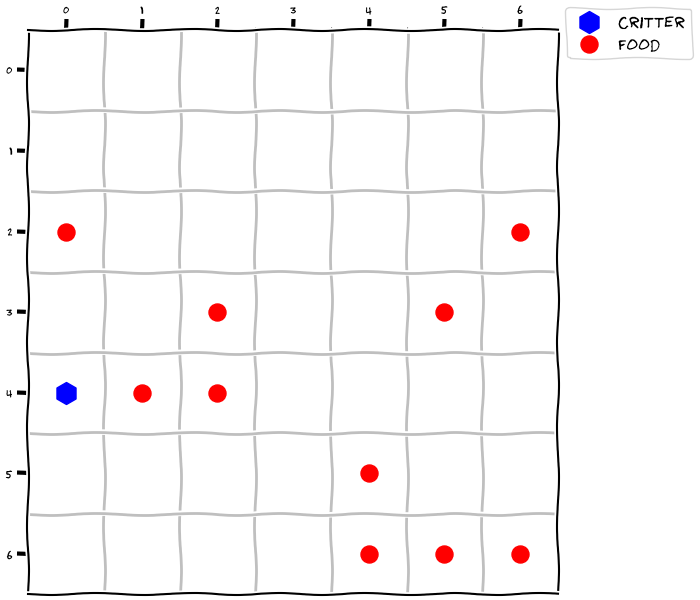

In [5]:
#to_remove solution


def init_loc(n_rows, n_cols, num, rng=None):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int, number of rows in the grid
    n_cols: int, number of columns in the grid
    num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
    rng:    instance of numpy.random's default rng. Used for reproducibility.

  Returns:
    int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
    rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
      the row indices and the second giving the col indices. Useful for indexing into
      an n_rows by n_cols numpy array.
    rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
  """
  # If no random number generator given, make one using predefined global SEED
  if rng is None:
    rng = np.random.default_rng(seed=SEED)
  # Choose 'num' unique random indices from a flat
  # 1D array of size n_rows*n_cols
  int_loc = rng.choice(n_rows * n_cols, num, replace=False)
  # Convert flat indices to 2D indices based on shape (n_rows, n_cols)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  # Transpose indices to get num x 2 array for easy plotting with matplotlib
  rc_plotting = np.array(rc_index).T
  # Return 1D flat indices, 2D indices for numpy array indexing
  # and 2D indices for plotting
  return int_loc, rc_index, rc_plotting

# Set the drawing style to 'xkcd'
with plt.xkcd():
  # Create a grid for the plot
  fig, ax = make_grid(7, 7)
  # Generate 11 unique locations on the grid
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11)
  # The first location is for the "critter"
  rc_critter = rc_plotting[0]
  plot_critter(fig, ax, rc_critter)
  # Remaining locations are for "food"
  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food)
  # Add legend outside the upper right corner
  fig.legend(loc='outside right upper')
  plt.show()

In [6]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M1")

---
# 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly and eats the food it happens to stumble upon. (Can you think of any organisms that employ this strategy? [hint](## "think about the way very very small biological things move around")). When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the code cell below to see what this looks like.

In [7]:
# @title Random Movement
# @markdown Don't worry about how this code works – just **run this cell** then click the start button and watch what happens.

rng = np.random.default_rng(seed=420)
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_food=10,
                    lifetime=30, rng=rng)
random_igwg = InteractiveGridworld(gwg, player=None, figsize=(5,4))
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.final_display)

*Question:* When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now click the start button again and run the simulation a few more times. Does the organism always eat the same amount of food or does it change between simulation runs? [explanation](## "The amount of food eaten varies from simulation run to simulation run,usually the organism manages to eat one or two or three pieces of food, sometimes more
sometimes less.")

*Bonus: see how the effectiveness of a strategy depends on the environment:*

Before we move on it's important to test that our simulation is running as we expect. Randomness can make testing hard, but can be overcome in part by setting up the environment in such a way that the outcome becomes deterministic. In the code cells bellow change how the Gridworld is initialized. By altering the size, shape and number of food items available create a scenario where the organism will always achieve perfect efficiency and a scenario where the organism will fail completely.

We will do this here by either providing food everywhere or nowhere.

In [8]:
###############################################################################
# TODO for students: Replace the ...'s in GridworldGame(...) to initialize a
# Gridworld where the organism is always 100% efficient. Food. Everywhere.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

gwg100 = GridworldGame(batch_size=1, n_cols=..., n_rows=..., num_food=...,
                       lifetime=30)
random_igwg_100 = InteractiveGridworld(gwg100, player=None, figsize=(5,4))
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.final_display)

NotImplementedError: ignored

In [9]:
#to_remove solution
gwg100 = GridworldGame(batch_size=1, n_cols=2, n_rows=2, num_food=3,
                       lifetime=30)
random_igwg_100 = InteractiveGridworld(gwg100, player=None, figsize=(5,4))
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.final_display)

Ok. We have just seen a super successful (albeit completely dumb) organism. Lets see if we can have an environment where any organism would fail (maybe surprisingly intelligence can not make food out of nothing).

In [10]:
###############################################################################
# TODO for students: Replace the ...'s in GridworldGame(...) to initialize a
# Gridworld where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

gwg0 = GridworldGame(batch_size=1, n_cols=..., n_rows=..., num_food=...,
                     lifetime=30)
random_igwg_0 = InteractiveGridworld(gwg0, player=None, figsize=(5,4))
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.final_display)

NotImplementedError: ignored

In [11]:
#to_remove solution
gwg0 = GridworldGame(batch_size=1, n_cols=2, n_rows=2, num_food=0,
                     lifetime=30)
random_igwg_0 = InteractiveGridworld(gwg0, player=None, figsize=(5,4))
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.final_display)

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M2")

---
# 1.1.1.3: Better Than Random Eating
Now it's your turn to actually control the organism with some level of intelligence (give it your all). Run the next cell and see how much more efficient than random drifting your control of the organism is in terms of food per movement. Does intelligence help?

In [13]:
# @title Controlled Movement
# @markdown Don't worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
gwg_c = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
h2h_igwg = Head2HeadGridworld(gwg_c, player0='human',
                              player1=None, figsize=(3,3),
                              )
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

Hopefully your performance was more successful than random flailing (if not, reset to the safe point). Even in this relatively simple and contrived foraging scenario intelligence can help a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? A fundamental purpose of nervous systems and brains is to solve problems of this kind — choosing which actions to take based on environmental inputs to maximize rewards.

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M3")

---
#1.1.1.4: Optimized Eating


Let's welcome a special guest, GW7x7-10-30, from the final chapter of this book. Utilizing a blend of deep reinforcement learning and Monte-Carlo search based on the AlphaZero optimization algorithm, GW7x7-10-30 has achieved mastery of the 7x7 Gridworld environment, with 10 food items and a game duration of 30 rounds.

The AlphaZero optimization algorithm finds inspiration from our understanding of the brain, and also draws upon various concepts from machine learning. As such, our specific computer implementation of the algorithm is unlikely to mirror the learning algorithms used by the brain in any particular detail.

Despite this lack of immediate correspondence, we can still gain significant insight by identifying the generalized form of learning problems that the brain solves together with the classes of optimization algorithms capable of feasibly solving these learning problems subject to biological constraints. These constraints derive from a multitude of factors based on the evolution, ecology, physiology, development, etc, of the organism. These insights will enable us to deduce the most probable types of learning algorithms employed by brains.

Subsequently, these deductions can guide us in seeking out the specific mechanisms and intricate details of the learning algorithms found in brains. Throughout this book, we will focus on introducing the general learning problems encountered by living organisms. We will identify different machine learning techniques that can presently solve these problems under various conditions. Furthermore, we will link the feasible machine learning solutions of these broader learning problems to our current empirical understanding of how a brain might implement similar solutions.

Our aim with this approach is to foster a principled, systematic, and integrative groundwork for neuroscience research. Now, let's run the next code cell to see who is more efficient – you or GW7x7-10-30. Reading this book will empower you to design the next generation of GW7x7-10-30.


In [15]:
# @title Optimized Movement
# @markdown Don't worry about how this code works – **run this cell** to set up the superorganism and an environment for it and you. Note, the superorganism will be **slow** to compute its moves if GPU acceleration is not enabled for this runtime. If possible, in the menu under `Runtime` -> "`Change runtime type`  select `GPU`.

# initialize the game, network, and MonteCarlo player
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_food=10,
                    lifetime=30)
pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=3,
                            default_rollouts=80, default_temp=0.02)


#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

# user in control versus mc player
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=2000))
h2h_igwg = Head2HeadGridworld(gwg, player0='human', player1=mcp, figsize=(4,4),
                              p0_long_name='The Human',
                              p1_long_name='gw7x7-10-30')
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

Who was more efficient in this environment you or gw7x7-10-30? If gw7x7-10-30 was better, you really have read this book 😉 (If you can't beat the AIs, at least learn how to program them.) Even if you were about as good as gw7x7-10-30 you still might want to read this book. A deep understanding of the optimization processes that shape behaviour in simple organism-environment systems like this one will allow for generalization to more intricate systems, specifically, a rich understanding of how brains generate adaptive behaviour as a result of optimization processes.

In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M4")

---
# Comprehension Quiz

In [17]:
# @title Quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
{
  "question": "What does a policy represent in the context of behaviour?",
  "type": "multiple_choice",
  "answers": [
  {
    "answer": "The evolutionary history of an organism",
    "correct": False,
    "feedback": "This is true in a broad and abstract sense, but there is a more precise answer here."
  },
  {
    "answer": "The environment in which an organism lives",
    "correct": False,
    "feedback": "There is a sense in which a policy shaped by evolution can reflect aspects of an organism's environment, but there is a more precise answer here."
  },
  {
    "answer": "The formal description of behaviour as a function that maps experiences to actions",
    "correct": True,
    "feedback": "Correct."
  },
  {
    "answer": "The randomness present in an organism's behavior",
    "correct": False,
    "feedback": "The policy might have randomness in it, but that's not what it is."
  }]
},
{
  "question": "How is a policy evaluated in terms of its goodness?",
  "type": "multiple_choice",
  "answers": [
  {
    "answer": "By integrating rewards and environmental signals into a loss/objective function",
    "correct": True,
    "feedback": "Correct, 'goodness' needs to be formalized in a loss/objective function"
  },
  {
    "answer": "By measuring the organism's fitness in the environment",
    "correct": True,
    "feedback": "This is one important way of evaluating a policy, but there is a more generally correct answer here."
  },
  {
    "answer": "By determining the amount of randomness present in the policy",
    "correct": False,
    "feedback": "Incorrect."
  },
  {
    "answer": "By analyzing the organism's evolutionary adaptations",
    "correct": False,
    "feedback": "Incorrect."
  }]
},
{
  "question": "What is stochasticity in the context of behaviour?",
  "type": "multiple_choice",
  "answers": [
    {
      "answer": "The specific niche an organism occupies within its environment",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "The ability of an organism to adapt to changing environmental conditions",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "The random elements present in both the environment and an organism's behavior",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "The process of optimizing a policy to achieve better outcomes",
      "correct": False,
      "feedback": "Incorrect."
    }]
  },
  {
    "question": "What is the main difference between random eating and controlled movement in the environment?",
    "type": "multiple_choice",
    "answers": [
    {
      "answer": "Random eating involves unpredictable movements, while controlled movement can be planned and strategic.",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "Random eating leads to higher efficiency, while controlled movement leads to lower efficiency.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "Random eating relies on external cues, while controlled movement relies on internal motivations.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "Random eating results in adaptive behavior, while controlled movement leads to stagnation.",
      "correct": False,
      "feedback": "Incorrect."
    }]
  },
  {
    "question": "What is the significance of GW7x7-10-30 in the context of optimized eating?",
    "type": "multiple_choice",
    "answers": [
    {
      "answer": "It represents a time-traveling superorganism with advanced cognitive abilities.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "It demonstrates the limitations of optimized behavior in a simple environment.",
      "correct": True,
      "feedback": "It could serve this purpose, though that wasn't the main reason we introduced it here."
    },
    {
      "answer": "It showcases the potential efficiency achievable through optimized behavior.",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "It serves as a benchmark for comparing different organisms' performance.",
      "correct": True,
      "feedback": "It could serve this purpose, though that wasn't the main reason we introduced it here."
    }]
  }
]


display_quiz(comprehension_quiz)

<IPython.core.display.Javascript object>